<span style="font-size:3em;">Ch5: The Mechanics of Learning
</span>

# 5.1 A timeless lesson in modeling

 We can argue that learning from data presumes the underlying model is not engineered to solve a specific problem and is instead capable of approximating a much wider family of functions
 
  In this book, we’re interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize themselves for
any one of many similar tasks using input and output pairs—in other words, general
models trained on data relevant to the specific task at hand. In particular, PyTorch is
designed to make it easy to create models for which the derivatives of the fitting error,
with respect to the parameters, can be expressed analytically

 In this book, we’re interested in models that are not engineered for solving a specific narrow task, but that can be automatically adapted to specialize themselves for
any one of many similar tasks using input and output pairs—in other words, general
models trained on data relevant to the specific task at hand. In particular, PyTorch is
designed to make it easy to create models for which the derivatives of the fitting error,
with respect to the parameters, can be expressed analytically.  

In order to make sure we get the key concepts right, we’ll start with a model
that is a lot simpler than a deep neural network

# 5.2 Learning is just parameter estimation

Given input data and the corresponding desired outputs (ground truth), as
well as initial values for the weights, the model is fed input data (forward pass), and a
measure of the error is evaluated by comparing the resulting outputs to the ground
truth. In order to optimize the parameter of the model—its weights—the change in
the error following a unit change in weights (that is, the gradient of the error with
respect to the parameters) is computed using the chain rule for the derivative of a
composite function (backward pass). The value of the weights is then updated in the
direction that leads to a decrease in the error

When we start, we’ll be doing everything by hand,
but by the end of the chapter we’ll be letting PyTorch do all the heavy lifting for us.

In [4]:
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#We will start by using temperature data 
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])

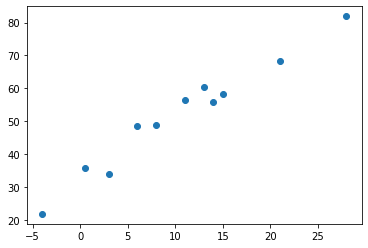

In [9]:
#quick 
plt.scatter(t_c,t_u)

 The
two may be linearly related—that is, multiplying t_u by a factor and adding a constant,
we may get the temperature in Celsius:
<b>t_c = w * t_u + b</b>

 Let’s flesh it out again: we have a model with some unknown parameters, and we
need to estimate those parameters so that the error between predicted outputs and
measured values is as low as possible. We notice that we still need to exactly define a
measure of the error. Such a measure, which we refer to as the loss function, should be
high if the error is high and should ideally be as low as possible for a perfect match.
Our optimization process should therefore aim at finding w and b so that the loss
function is at a minimum.


# 5.3 Less loss is what we want
A loss function (or cost function) is a function that computes a single numerical value
that the learning process will attempt to minimize. 

In our case,
that would be the difference between the predicted temperatures t_p output by our
model and the actual measurements: t_p – t

<b> Mean Squared Error</b> is a common loss function for regression.

MSE has a clear minimum at 0 and grows monotically as the prediction moves away from the true value in both directions. Because steepness of the growth also monotically increases away from the minimum, it is a <b>convex</b> function. Since our model is linear, the loss as a function of w and b are also convex


 Cases where the loss is a convex function of the model parameters are usually great to deal with because we can find a minimum very efficiently through specialized algorithms. However, we will instead use less powerful but more
generally applicable methods in this chapter. We do so because for the deep neural networks we are ultimately interested in, the loss is not a convex function of the inputs.

 For our two loss functions <b>|t_p – t_c| and (t_p – t_c)^2</b>, as shown in figure 5.4,
we notice that the square of the differences behaves more nicely around the minimum: the derivative of the error-squared loss with respect to t_p is zero when t_p
equals t_c. The absolute value, on the other hand, has an undefined derivative right
where we’d like to converge. This is less of an issue in practice than it looks like, but
we’ll stick to the square of differences for the time being.

## 5.3.1 From problem back to PyTorch

 Now we need to set the learning process in motion and feed it actual data. 
 We’ve already created our data tensors, so now let’s write out the model as a
Python function:

In [10]:
def model(t_u, w, b):
    return w * t_u + b

We’re expecting t_u, w, and b to be the input tensor, weight parameter, and bias
parameter, respectively. In our model, the parameters will be PyTorch scalars (aka zero-dimensional tensors), and the product operation will use broadcasting to yield
the returned tensors.

Now lets define loss:

In [12]:
def loss_fn(t_p,t_c):
    '''
    Mean Squared Loss
    '''
    squared_dffs = (t_p - t_c)**2
    return squared_dffs.mean()

In [51]:
#Now lets initialize w and b and create the model
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [52]:
#loss
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

<b>Broadcasting:</b>


We mentioned broadcasting in chapter 3, and we promised to look at it more carefully
when we need it. In our example, we have two scalars (zero-dimensional tensors) w
and b, and we multiply them with and add them to vectors (one-dimensional tensors)
of length b.
Usually—and in early versions of PyTorch, too—we can only use element-wise binary
operations such as addition, subtraction, multiplication, and division for arguments
of the same shape. The entries in matching positions in each of the tensors will be
used to calculate the corresponding entry in the result tensor.


Broadcasting, which is popular in NumPy and adapted by PyTorch, relaxes this assumption for most binary operations. It uses the following rules to match tensor elements:
- For each index dimension, counted from the back, if one of the operands is
size 1 in that dimension, PyTorch will use the single entry along this dimension with each of the entries in the other tensor along this dimension.


- If both sizes are greater than 1, they must be the same, and natural matching
is used.


- If one of the tensors has more index dimensions than the other, the entirety
of the other tensor will be used for each entry along these dimensions.

This sounds complicated (and it can be error-prone if we don’t pay close attention, which
is why we have named the tensor dimensions as shown in section 3.4), but usually,
we can either write down the tensor dimensions to see what happens or picture what
happens by using space dimensions to show the broadcasting, as in the following figure.

<b>Note:</b> This is for element-wise multiplication below not matrix multiplication(dot product)

In [53]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)

print(f'shapes: x: {x.shape} y: {y.shape}')
print(f"z: {z.shape}, a: {a.shape}")

shapes: x: torch.Size([]) y: torch.Size([3, 1])
z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


In [54]:
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


# 5.4 Down along the gradient

We’ll optimize the loss function with respect to the parameters using the gradient
descent algorithm.  Gradient descent is actually a very simple idea, and it scales up surprisingly well to large neural network models with millions of parameters.

## 5.4.1 Decreasing loss

The idea to to compute the rate of change of the loss with respect to each parameter, and modify each parameter in the direction of decreasing loss

In [69]:
delta = 0.1

#this backwards slash allows us to write on the next line, its called line continutation character
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b), t_c) -
loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [70]:
loss_rate_of_change_w

tensor(4517.2979)

This is saying that in the neighborhood of the current values of w and b, a unit
increase in w leads to some change in the loss. If the change is negative, then we need
to increase w to minimize the loss, whereas if the change is positive, we need to
decrease w

It is also wise to
change the parameters slowly in general, because the rate of change could be dramatically different at a distance from the neighborhood of the current w value. Therefore,
we typically should scale the rate of change by a small factor. This scaling factor has
many names; the one we use in machine learning is <b>learning_rate</b>:

In [75]:
learning_rate = 1e-2

w = w - learning_rate* loss_rate_of_change_w

#Can do the same with b:
loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta), t_c) -
loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b=b- learning_rate * loss_rate_of_change_b

This represents the basic parameter-update step for gradient descent. By reiterating
these evaluations (and provided we choose a small enough learning rate), we will
converge to an optimal value of the parameters for which the loss computed on the
given data is minimal.

## 5.4.2 Getting analytical

In a model with two or more parameters like the one we’re
dealing with, we compute the individual derivatives of the loss with respect to each
parameter and put them in a vector of derivatives: the gradient.

In order to compute the derivative of the loss with respect to a parameter, we can
apply the chain rule and compute the derivative of the loss with respect to its input
(which is the output of the model), times the derivative of the model with respect to
the parameter:



dloss_fn / d w = (dloss_fn / d t_p) * (d t_p / d w)  


In [76]:
def loss_fn(t_p,t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

#Remembering that d x^2 / d x = 2 x, we get
def dloss_fn(t_p, t_c):
    dsg_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsg_diffs

In [77]:
#Applying the derivatives to the model from earlier get
def dmodel_dw(t_u, w, b):
    return t_u
def dmodel_db(t_u,w,b):
    return 1.0

<b>DEFINING THE GRADIENT FUNCTION: </b>
Putting all of this together, the function returning the gradient of the loss with respect
to w and b is

In [79]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p,t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u,w,b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

## 5.4.3 Iterating to fit the model

We now have everything in place to optimize our parameters. Starting from a tentative
value for a parameter, we can iteratively apply updates to it for a fixed number of iterations, or until w and b stop changing. There are several stopping criteria; for now,
we’ll stick to a fixed number of iterations.

<b>THE TRAINING LOOP: </b>
Since we’re at it, let’s introduce another piece of terminology. We call a training iteration during which we update the parameters for all of our training samples an epoch.

In [80]:
#The complete training loop looks like this 
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b) # forward pass
        loss = loss_fn(t_p, t_c) 
        grad = grad_fn(t_u, t_c, t_p, w, b) # Backward pass
        
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params

In [85]:
#Here is a training loop that gives us more info for each epoch
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('\n    Params:', params)
                print('    Grad:  ', grad,'\n')
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [86]:
#Now lets train our model
training_loop(n_epochs=100,
             learning_rate=1e-2,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644

    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2969,   82.6000]) 

Epoch 2, Loss 5802485.500000

    Params: tensor([2568.4014,   45.1637])
    Grad:   tensor([-261257.4219,   -4598.9712]) 

Epoch 3, Loss 19408035840.000000

    Params: tensor([-148527.7344,   -2616.3933])
    Grad:   tensor([15109614.0000,   266155.7188]) 

...
Epoch 10, Loss 90901154706620645225508955521810432.000000

    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17]) 

Epoch 11, Loss inf

    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19]) 



tensor([-1.8590e+19, -3.2746e+17])

<b> OVERTRAINING: </b>  Wait, what happened? Our training process literally blew up, leading to losses becoming inf. This is a clear sign that params is receiving updates that are too large, and
their values start oscillating back and forth as each update overshoots and the next
overcorrects even more. The optimization process is unstable: it diverges instead of
converging to a minimum. We want to see smaller and smaller updates to params, not
larger

How can we limit the magnitude of learning_rate * grad? Well, that looks easy. We
could simply choose a smaller learning_rate, and indeed, the learning rate is one of
the things we typically change when training does not go as well as we would like.8
 
 We usually change learning rates by orders of magnitude, so we might try with 1e-3 or
1e-4, which would decrease the magnitude of the updates by orders of magnitude.
Let’s go with 1e-4 and see how it works out:

In [87]:
#again with lr=1e-4
training_loop(n_epochs=100,
             learning_rate=1e-4,
             params=torch.tensor([1.0,0.0]),
             t_u=t_u,
             t_c=t_c)

Epoch 1, Loss 1763.884644

    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000]) 

Epoch 2, Loss 323.090546

    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843]) 

Epoch 3, Loss 78.929634

    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122]) 

...
Epoch 10, Loss 29.105242

    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544]) 

Epoch 11, Loss 29.104168

    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384]) 

...
Epoch 99, Loss 29.023582

    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226]) 

Epoch 100, Loss 29.022669

    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226]) 



tensor([ 0.2327, -0.0438])

Nice—the behavior is now stable. But there’s another problem: the updates to parameters are very small, so the loss decreases very slowly and eventually stalls. We could
obviate this issue by making learning_rate adaptive: that is, change according to the
magnitude of updates. There are optimization schemes that do that, and we’ll see one
toward the end of this chapter.


 However, there’s another potential troublemaker in the update term: the gradient
itself. Let’s go back and look at grad at epoch 1 during optimization. 

## 5.4.4 Normalizing inputs

We can see that the first-epoch gradient for the weight is about 50 times larger than
the gradient for the bias. This means the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update
one will be so large as to be unstable for the other; and a rate that’s appropriate for
the other won’t be large enough to meaningfully change the first. That means we’re
not going to be able to update our parameters unless we change something about our
formulation of the problem. We could have individual learning rates for each parameter, but for models with many parameters, this would be too much to bother with


 There’s a simpler way to keep things in check: changing the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get
too far from the range of –1.0 to 1.0, roughly speaking.

In [88]:
#Lets try a simple fix by multiplying t_u by 0.1
t_un = 0.1 * t_u

training_loop(
n_epochs = 100,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c)

Epoch 1, Loss 80.364342

    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400]) 

Epoch 2, Loss 37.574917

    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864]) 

Epoch 3, Loss 30.871077

    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587]) 

...
Epoch 10, Loss 29.030487

    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295]) 

Epoch 11, Loss 28.941875

    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264]) 

...
Epoch 99, Loss 22.214186

    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208]) 

Epoch 100, Loss 22.148710

    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165]) 



tensor([ 2.7553, -2.5162])

In [89]:
#Let’s run the loop for enough iterations to see the changes in params get small. We’ll change n_epochs to 5,000:
params = training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0]),
t_u = t_un,
t_c = t_c,
print_params = False)

params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574917
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030487
Epoch 11, Loss 28.941875
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

We are using a Python trick called argument unpacking here: *params means to pass the
elements of params as individual arguments. In Python, this is usually done with lists
or tuples, but we can also use argument unpacking with PyTorch tensors, which are
split along the leading dimension. So here, model(t_un, *params) is equivalent to
model(t_un, params[0], params[1]).

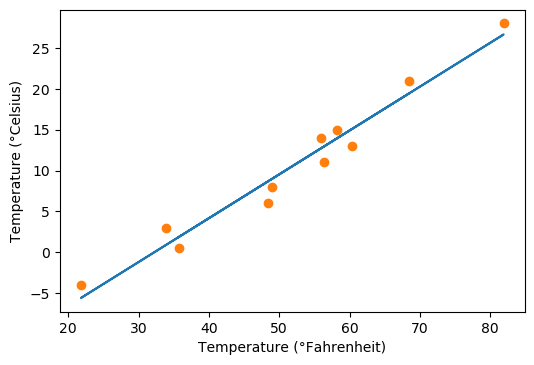

In [94]:
#Lets try plotting the data
import matplotlib.pyplot as plt

%matplotlib inline

t_p = model(t_un, *params) #The *params means we are using argument unpacking


fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")

plt.plot(t_u.numpy(), t_p.detach().numpy())  #plotiing the raw unknown values
plt.plot(t_u.numpy(), t_c.numpy(), 'o');

# 5.5 PyTorch’s autograd: Backpropagating all things
We just saw a simple example of backpropagation: we computed the gradient of a composition of functions—the model and the loss—with
respect to their innermost parameters (w and b) by propagating derivatives backward
using the chain rule. The basic requirement here is that all functions we’re dealing
with can be differentiated analytically. If this is the case, we can compute the gradient—what we earlier called “the rate of change of the loss”—with respect to the
parameters in one sweep.

## 5.5.1 Computing the gradient automatically

This is when PyTorch tensors come to the rescue, with a PyTorch component called
autograd. PyTorch tensors can remember where they come from, in terms of the operations and
parent tensors that originated them, and they can automatically provide the chain of
derivatives of such operations with respect to their inputs. This means we won’t need
to derive our model by hand;10 given a forward expression, no matter how nested,
PyTorch will automatically provide the gradient of that expression with respect to its
input parameters.


<b>APPLYING AUTOGRAD</b>

In [101]:
def model(t_u, w, b):
    return w * t_u + b


def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

#Initialize tensor
params = torch.tensor([1.0,0.0], requires_grad=True)

USING THE GRAD ATTRIBUTE
Notice the requires_grad=True argument to the tensor constructor? That argument
is telling PyTorch to track the entire family tree of tensors resulting from operations
on params. In other words, any tensor that will have params as an ancestor will have
access to the chain of functions that were called to get from params to that tensor. In
case these functions are differentiable (and most PyTorch tensor operations will be),
the value of the derivative will be automatically populated as a grad attribute of the
params tensor.


 In general, all PyTorch tensors have an attribute named grad. Normally, it’s None:

In [103]:
params.grad is None

True

All we have to do to populate it is to start with a tensor with requires_grad set to
True, then call the model and compute the loss, and then call backward on the loss
tensor:

In [104]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

At this point, the grad attribute of params contains the derivatives of the loss with
respect to each element of params.
 
 When we compute our loss while the parameters w and b require gradients, in
addition to performing the actual computation, PyTorch creates the autograd graph
with the operations as nodes. When we call loss.backward(), PyTorch traverses this graph in the reverse
direction to compute the gradients, as shown by the arrows in the bottom row of
the figure. 

<b> ACCUMULATING GRAD FUNCTIONS</b>

We could have any number of tensors with requires_grad set to True and any composition of functions. In this case, PyTorch would compute the derivatives of the loss
throughout the chain of functions (the computation graph) and accumulate their values in the grad attribute of those tensors (the leaf nodes of the graph).


<b> Alert! Big gotcha ahead. This is something PyTorch newcomers—and a lot of more
experienced folks, too—trip up on regularly. We just wrote accumulate, not store.
WARNING Calling backward will lead derivatives to accumulate at leaf nodes.
We need to zero the gradient explicitly after using it for parameter updates. </b>

Let’s repeat together: calling backward will lead derivatives to accumulate at leaf nodes.
So if backward was called earlier, the loss is evaluated again, backward is called again
(as in any training loop), and the gradient at each leaf is accumulated (that is,
summed) on top of the one computed at the previous iteration, which leads to an
incorrect value for the gradient.


 In order to prevent this from occurring, <b>we need to zero the gradient explicitly at each
iteration</b>. We can do this easily using the in-place zero_ method:

In [105]:
if params.grad is not None:
    params.grad.zero_()

<b>NOTE:</b> You might be curious why zeroing the gradient is a required step
instead of zeroing happening automatically whenever we call backward.
Doing it this way provides more flexibility and control when working with gradients in complicated models.

In [110]:
#Now lets put it all together

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()


        with torch.no_grad():  #So we dont accumlate gradients in the backward pass
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

Note that our code updating params is not quite as straightforward as we might have
expected. First, we are wrap the update in a
no_grad context using the Python with statement. This means within the with block,
the PyTorch autograd mechanism should look away:
that is, not add edges to the forward graph. In fact, when we are executing this bit of code, the forward graph that
PyTorch records is consumed when we call backward, leaving us with the params leaf
node. But now we want to change this leaf node before we start building a fresh forward graph on top of it. While this use case is usually wrapped inside the optimizers
we discuss in section 5.5.2, we will take a closer look when we see another common use
of no_grad in section 5.5.4.



 Second, we update params in place. This means we keep the same params tensor
around but subtract our update from it. When using autograd, we usually avoid inplace updates because PyTorch’s autograd engine might need the values we would be
modifying for the backward pass. Here, however, we are operating without autograd,
and it is beneficial to keep the params tensor. Not replacing the parameters by assigning new tensors to their variable name will become crucial when we register our
parameters with the optimizer in section 5.5.2.

In [111]:
#Lets try the full thing
training_loop(
n_epochs = 5000,
learning_rate = 1e-2,
params = torch.tensor([1.0, 0.0], requires_grad=True),  #adding requires_grad=True is key 
t_u = t_un,
t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

## 5.5.2 Optimizers a la carte

 The torch module has an optim submodule where we can find classes implementing different
optimization algorithms. This saves us from the boilerplate busywork
of having to update each and every parameter to our model ourselves. Here’s an abridged list

In [113]:
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'lr_scheduler']

Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically
with requires_grad set to True) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their grad attribute

Each optimizer exposes two methods: zero_grad and step. 
- <b>zero_grad:</b> zeroes the
grad attribute of all the parameters passed to the optimizer upon construction. 
- <b>step:</b>
updates the value of those parameters according to the optimization strategy implemented by the specific optimizer.

In [125]:
#Lets create params and an optimizer
params = torch.tensor([1.0,0.0], requires_grad=True)

learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

Here SGD stands for stochastic gradient descent. Actually, the optimizer itself is exactly a
vanilla gradient descent (as long as the momentum argument is set to 0.0, which is the
default). The term stochastic comes from the fact that the gradient is typically obtained
by averaging over a random subset of all input samples, called a minibatch. However, the
optimizer does not know if the loss was evaluated on all the samples (vanilla) or a random subset of them (stochastic), so the algorithm is literally the same in the two cases.

In [126]:
params

tensor([1., 0.], requires_grad=True)

In [127]:
#Lets try it out
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step()
params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

The value of params is updated upon calling step without us having to touch it ourselves! What happens is that the optimizer looks into params.grad and updates
params, subtracting learning_rate times grad from it, exactly as in our former handrolled code.

In [128]:
#One thing we need to add is zero the gradients

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([1.7761, 0.1064], requires_grad=True)

In [129]:
#Now lets put it all together
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [130]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)  #important we use the same params in model and optimizer

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

<b>TESTING OTHER OPTIMIZERS</b>

In order to test more optimizers, all we have to do is instantiate a different optimizer,
say Adam, instead of SGD. The rest of the code stays as it is. 

 We won’t go into much detail about Adam; suffice to say that it is a more sophisticated optimizer in which the learning rate is set adaptively. In addition, it is a lot less
sensitive to the scaling of the parameters—so insensitive that we can go back to using the original (non-normalized) input t_u, and even increase the learning rate to 1e-1,
and Adam won’t even blink:

In [131]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612903
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

The optimizer is not the only flexible part of our training loop. Let’s turn our attention to the model. In order to train a neural network on the same data and the same
loss, all we would need to change is the model function. It wouldn’t make particular
sense in this case, since we know that converting Celsius to Fahrenheit amounts to a
linear transformation, but we’ll do it anyway in chapter 6. We’ll see quite soon that
neural networks allow us to remove our arbitrary assumptions about the shape of the
function we should be approximating. Even so, we’ll see how neural networks manage
to be trained even when the underlying processes are highly nonlinear (such in the
case of describing an image with a sentence, as we saw in chapter 2).


## 5.5.3 Training, validation, and overfitting

 The first action we can take to combat overfitting is recognizing that it might happen. In order to do so we must take a few data points
out of our dataset (the validation set) and only fit our model on the remaining data
points (the training set),

<b>rule 1:</b> if the training loss is not decreasing, chances are the
model is too simple for the data. The other possibility is that our data just doesn’t contain meaningful information that lets it explain the output

<b>rule 2:</b>  if the training loss and the validation loss
diverge, we’re overfitting


One solution is adding penalization terms to the loss function, to
make it cheaper for the model to behave more smoothly and change more slowly (up
to a point). Another is to add noise to the input samples, to artificially create new data
points in between training data samples and force the model to try to fit those, too.
There are several other ways, all of them somewhat related to these. But the best favor
we can do to ourselves, at least as a first move, is to make our model simpler. From an
intuitive standpoint, a simpler model may not fit the training data as perfectly as a
more complicated model would, but it will likely behave more regularly in between
data points.

 Therefore, in order to choose the right size for a neural network model in
terms of parameters, the process is based on two steps: increase the size until it fits,
and then scale it down until it stops overfitting.
 We’ll see more about this in chapter 12—we’ll discover that our life will be a balancing act between fitting and overfitting
 
 
<b> Splitting a Dataset</b>

Shuffling the elements of a tensor amounts to finding a permutation of its indices.
The randperm function does exactly this

In [132]:
n_samples= t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  8,  6,  7,  2,  1,  3,  0,  4]), tensor([5, 9]))

In [137]:
#Got the indices now lets create the train and val sets
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

Our training loop doesn’t really change. We just want to additionally evaluate the validation loss at every epoch, to have a chance to recognize whether we’re overfitting

In [148]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u,
                  train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()  #Notice that there is no val_loss.backward() since we dnt want to train on it
        optimizer.step()
        
        if epoch <=3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}," f" Validation loss {val_loss.item():.4f}")
            
    return params

In [139]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 3000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 91.7660, Validation loss 29.0568
Epoch 2, Training loss 43.7766, Validation loss 2.3025
Epoch 3, Training loss 36.0900, Validation loss 3.5195
Epoch 500, Training loss 7.0920, Validation loss 4.6118
Epoch 1000, Training loss 3.4116, Validation loss 4.0901
Epoch 1500, Training loss 2.9273, Validation loss 3.9970
Epoch 2000, Training loss 2.8636, Validation loss 3.9759
Epoch 2500, Training loss 2.8552, Validation loss 3.9700
Epoch 3000, Training loss 2.8541, Validation loss 3.9680


tensor([  5.4240, -17.2490], requires_grad=True)

## 5.5.4 Autograd nits and switching it off

 The curious reader will have an embryo of a question at this point. The model is
evaluated twice—once on train_t_u and once on val_t_u—and then backward is
called. Won’t this confuse autograd? Won’t backward be influenced by the values generated during the pass on the validation set?

 Luckily for us, this isn’t the case. The first line in the training loop evaluates model
on train_t_u to produce train_t_p. Then train_loss is evaluated from train_t_p.
This creates a computation graph that links train_t_u to train_t_p to train_loss.
When model is evaluated again on val_t_u, it produces val_t_p and val_loss. In this
case, a separate computation graph will be created that links val_t_u to val_t_p to
val_loss. Separate tensors have been run through the same functions, model and
loss_fn, generating separate computation graphs


The only tensors these two graphs have in common are the parameters. When we call
backward on train_loss, we run backward on the first graph. In other words, we
accumulate the derivatives of train_loss with respect to the parameters based on the
computation generated from train_t_u.
 If we (incorrectly) called backward on val_loss as well, we would accumulate the
derivatives of val_loss with respect to the parameters on the same leaf nodes.

 Calling backward on val_loss would lead to gradients accumulating in the params tensor, on top of those generated during the train_loss.backward() call. In this case, we would effectively train our model on the whole dataset (both
training and validation), since the gradient would depend on both

<b> There’s another element for discussion here. </b>
 
 Since we’re not ever calling backward on val_loss, why are we building the graph in the first place? We could in fact
just call model and loss_fn as plain functions, without tracking the computation.
However optimized, building the autograd graph comes with additional costs that we
could totally forgo during the validation pass, especially when the model has millions
of parameters.

 In order to address this, PyTorch allows us to switch off autograd when we don’t
need it, using the torch.no_grad context manager. We can make sure this works by
checking the value of the requires_grad attribute on the val_loss tensor:

In [140]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False  #Dont need this but makes sure grad is off
            
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
    return params

Using the related set_grad_enabled context, we can also condition the code to run
with autograd enabled or disabled, according to a Boolean expression—typically indicating whether we are running in training or inference mode. We could, for instance,
define a calc_forward function that takes data as input and runs model and loss_fn
with or without autograd according to a Boolean train_is argument:

In [142]:
def calc_forward(t_u, t_c, is_train=True):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

# Exercises

1. Redefine the model to be w2 * t_u ** 2 + w1 * t_u + b

In [143]:
def model(t_u, w1, w2, b):
    return (w2 * t_u)**2 + w1*t_u + b

In [151]:
params = torch.tensor([1.0,1.0,0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 681.0540, Validation loss 652.1264
Epoch 2, Training loss 46.4894, Validation loss 54.6286
Epoch 3, Training loss 27.5840, Validation loss 30.2537
Epoch 500, Training loss 12.3546, Validation loss 4.5737
Epoch 1000, Training loss 9.7718, Validation loss 3.3101
Epoch 1500, Training loss 8.0027, Validation loss 2.4447
Epoch 2000, Training loss 6.7918, Validation loss 1.8536
Epoch 2500, Training loss 5.9630, Validation loss 1.4505
Epoch 3000, Training loss 5.3955, Validation loss 1.1761
Epoch 3500, Training loss 5.0064, Validation loss 0.9895
Epoch 4000, Training loss 4.7391, Validation loss 0.8627
Epoch 4500, Training loss 4.5550, Validation loss 0.7767
Epoch 5000, Training loss 4.4275, Validation loss 0.7185


tensor([-0.9373,  0.7554, -0.9603], requires_grad=True)